# Normalization Curves in Uniform-grid Spatial R-Fields

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from NrnResponse import *
from NSclasses import *
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns

In [3]:
def plot_2D(data_info,title,input_label,output_label,axis_bounds=None,xscale=None,yscale=None):

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)

    for info_cache in data_info:
        plt.plot(info_cache[0][0],info_cache[0][1],info_cache[1],label=info_cache[2],linewidth=1.5,markersize=3)

    plt.title(title,fontsize=24)
    plt.xlabel(input_label,fontsize=20)
    plt.ylabel(output_label,fontsize=20)
    if not axis_bounds == None:
        plt.axis(axis_bounds)
    if not xscale == None:
        plt.xscale(xscale)
    if not yscale == None:
        plt.yscale(yscale)
    plt.legend(loc='best',fontsize=14)
    plt.show()
    
def PlotUniformGrid(num, neurons):
    #Plot receptive fields of neurons in a uniform grid set-up
    assert(len(neurons) == num**2)
    neuron_im = [0]*(num**2)
    
    for i in range(num):
        for j in range(num):
            neuron_im[i+j*num] = neurons[i+j*num].PosCurve()
            
    fig = plt.figure(figsize=(10, 10))
    plt.title('Uniform grid Spatial R-Fields for {} neurons'.format(num**2), 
              fontsize = 16)
    plt.axis('off')
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
             nrows_ncols=(num, num),  # creates grid of axes
             axes_pad=0.3,  # pad between axes in inch.
             share_all = True,
             )
    for ax, im in zip(grid, neuron_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, extent = [-1, 1, -1, 1], aspect='auto')

    plt.show()


# Normalization model
$$
R = \gamma \frac{I^{n}}{\sigma^{n} + I^{n}_m + I^{n}}
$$

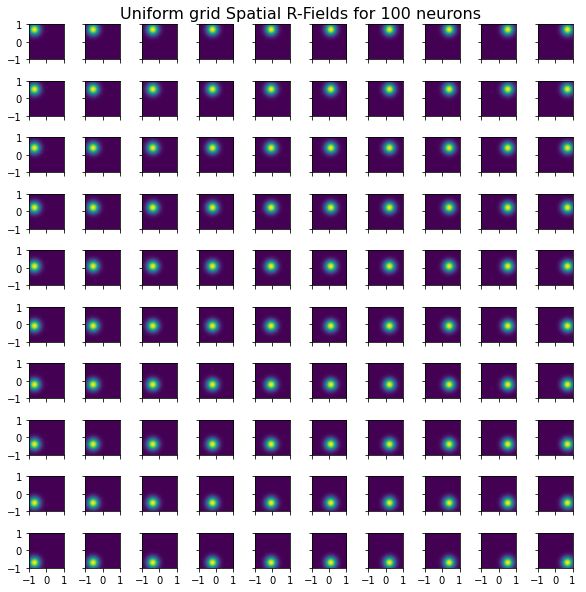

In [8]:
def initialization(nodes, flag = 0):
    assert(nodes >= 5)
    
    Grid = Mygrid(1, 1, 50, 50)
    Tar = MyNrn(0, 0, np.pi/2, Grid)
    Stimu = MyPtStm(0.1, -0.1, np.pi/2-0.1) #slight offset from target
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    Xspace = np.linspace(-1+0.3, 1-0.3, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.3, 1-0.3, num=nodes, endpoint=True)
    
    #Xspace = np.delete(Xspace, np.where(abs(Xspace-Tar.x) < 0.2))
    #Yspace = np.delete(Yspace, np.where(abs(Yspace-Tar.y) < 0.2))
    
    Neurons = [0]*(nodes**2)
    Res = [0]*(nodes**2)
    
    for i in range(nodes):
        for j in range(nodes):
            x = Xspace[i]
            y = Yspace[j]
            Neurons[i+j*nodes] = MyNrn(x, y, 
                                             (i+j*nodes)*np.pi/(nodes**2), Grid)
            Res[i+j*nodes] = NrnResponse(Neurons[i+j*nodes], Stimu, Grid)
            
    ini =  NrnResponse(Tar, Stimu, Grid)
    ini_m = sum(Res)
    
    if (flag == 1):
        PlotUniformGrid(nodes, Neurons)
    else:
        return ini, ini_m
initialization(10, 1)



In [9]:
def NormalizedR(ini, ini_m, gamma = 1, sigma = 0, exp = 1):
    nom = ini**exp
    denom = sigma**exp + ini_m**exp + nom
    return gamma* (nom/denom)

def GammaVar(gamma, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, gamma, 0, 1)

def SigmaVar(sigma, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, 1, sigma, 1)

def expVar(exp, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, 1, 0, exp)

In [52]:
#DataFrame set-up
N = 10
h_gam = 0.5
h_sig = 1.
h_exp = 0.1
ini, ini_m = initialization(N)
# 1 <= gamma <= 3
gamma = np.arange(1,3+h_gam, h_gam)
# 0 <= sigma <= 5
sigma = np.arange(0,5+h_sig, h_sig)
# 1 <= exp <= 3
exp = np.arange(1,3+h_exp, h_exp)
res = dict()
for s in sigma:
    for g in gamma:
        col = []
        for e in exp:
            col.append(NormalizedR(ini, ini_m, g, s, e))
        
        res['g: {0} s: {1}'.format(g, s)] = col
        
txt = []
for e in exp:
    txt.append('e: {0} '.format(e))
data = pd.DataFrame(data = res, index = txt)
print(data.shape)

(21, 30)


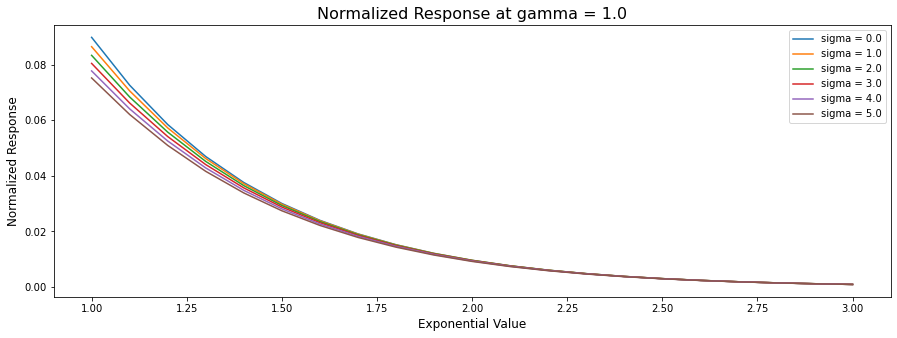

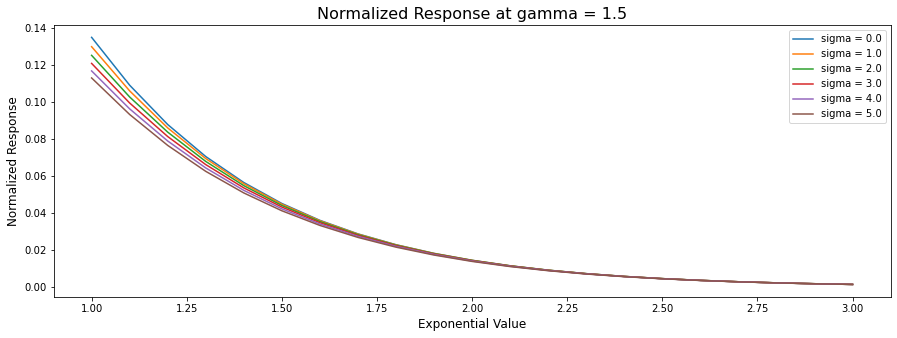

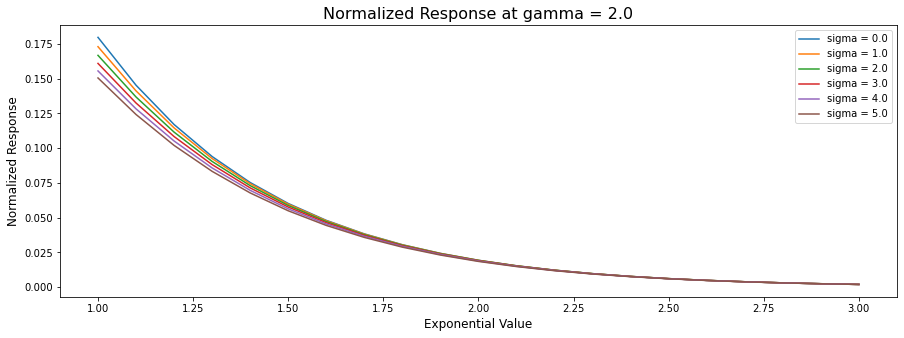

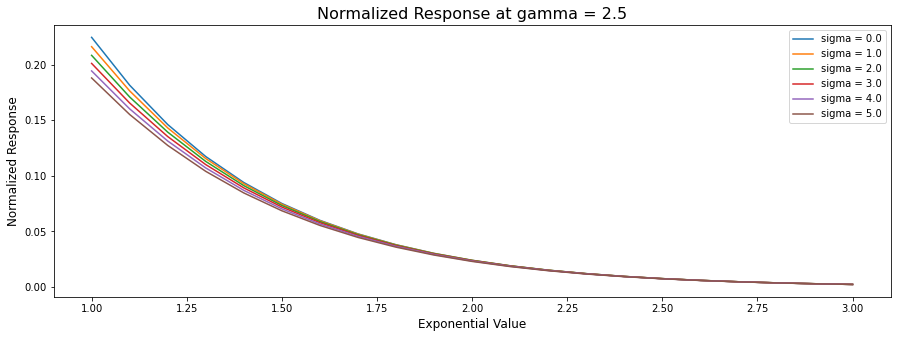

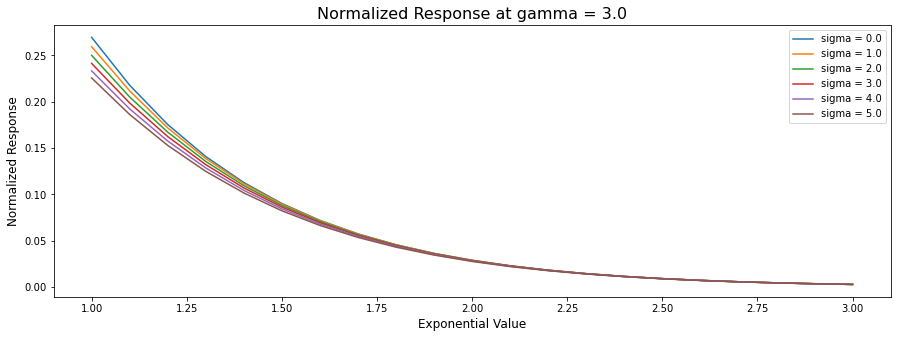

In [53]:

def PlotNormalized(data, g, sigma, exp):
    #plot normalized response value with fixed gamma
    #changing sigma and exponential
    fig = plt.figure(figsize=(15, 5))
    labels = []
    for s in sigma:
        plt.plot(exp, data['g: {0} s: {1}'.format(g, s)])
        labels.append('sigma = {}'.format(s))
        plt.legend(labels)

        plt.xlabel('Exponential Value', fontsize = 12)
        plt.ylabel('Normalized Response', fontsize = 12)
        plt.title('Normalized Response at gamma = {}'.format(g), fontsize = 16)
        plt.show

for g in gamma:
    PlotNormalized(data, g, sigma, exp)

Created by: Ricky Huang